In [76]:
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

videos = list(Path("../data/videos").glob("*.mp4"))
video = videos[0]
# load a video and display it
cap = cv2.VideoCapture(video.as_posix())
# check framerate
fps = cap.get(cv2.CAP_PROP_FPS)
fps

25.0

In [73]:
from tqdm import tqdm


def get_frames(cap):
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        yield frame


def get_subset(img):
    img = img[600:700, :400]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.threshold(img, 255 * 0.9, 255, cv2.THRESH_BINARY)[1]
    # lets also flood fill the background with white starting at the bottom left
    cv2.floodFill(img, None, (0, 0), 255)
    # truncate again
    img = img[30:70, 50:400]
    # invert so text is 255
    img = cv2.bitwise_not(img)
    return img


cap = cv2.VideoCapture(video.as_posix())
frames = []
for frame in tqdm(get_frames(cap)):
    subset = get_subset(frame)
    frames.append(subset)

2180it [00:03, 678.99it/s]


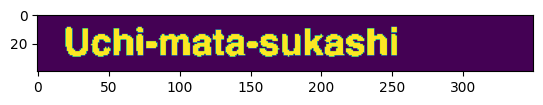

1750


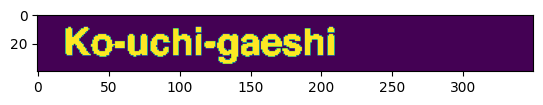

1875


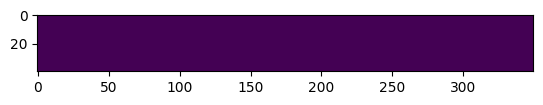

2125


In [128]:
for i in [25 * 70, 25 * 75, 25 * 85]:
    plt.imshow(frames[i])
    plt.show()
    print(i)

In [131]:
np.sum(np.abs(frames[25 * 75] - frames[25 * 85]))

479655

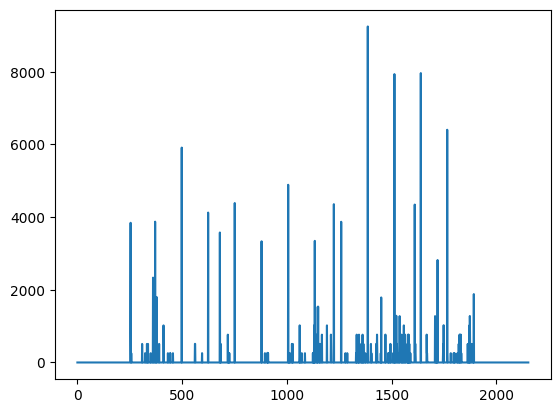

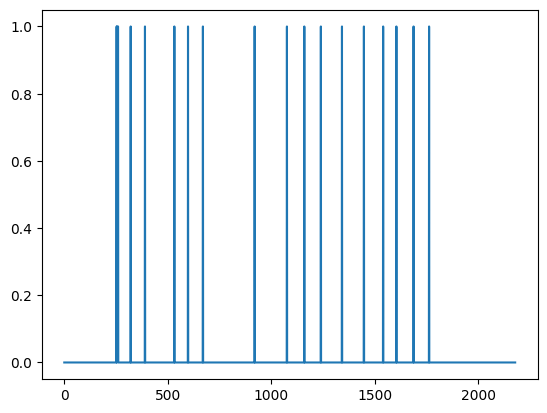

In [138]:
diffs = [0]
for i in range(1, len(frames)):
    diffs.append(np.sum(np.abs(frames[i] - frames[i - 1])))
diffs = np.array(diffs)
# diffs = np.log(diffs + 1 + np.random.rand(len(diffs)))

scores = (diffs - np.mean(diffs)) / np.std(diffs)
# mad = np.median(np.abs(diffs - np.median(diffs)))
# scores = 0.6745 * np.abs(diffs - np.median(diffs))/ mad

plt.plot(diffs[np.where(diffs < 10000)])
plt.show()

plt.plot(scores > 1)
plt.show()

In [141]:
idx = np.where(scores > 1)

start = np.where(diffs > 0)[0][0]
end = np.where(diffs > 0)[0][-1]
points = [start] + idx[0].tolist() + [end]
print(points)

# generate tuples of (start, end) index
intervals = []
for i in range(1, len(points)):
    a, b = points[i - 1], points[i]
    if b - a > 5:
        intervals.append((a, b - 1))
print(intervals)
print(len(intervals))

[253, 253, 255, 256, 257, 258, 259, 260, 321, 390, 532, 598, 670, 920, 1076, 1160, 1240, 1342, 1448, 1541, 1605, 1688, 1763, 1919]
[(260, 320), (321, 389), (390, 531), (532, 597), (598, 669), (670, 919), (920, 1075), (1076, 1159), (1160, 1239), (1240, 1341), (1342, 1447), (1448, 1540), (1541, 1604), (1605, 1687), (1688, 1762), (1763, 1918)]
16


In [150]:
# let's start saving files in chunks


def calculate_intervals(video):
    cap = cv2.VideoCapture(video.as_posix())
    frames = []
    for frame in tqdm(get_frames(cap)):
        subset = get_subset(frame)
        frames.append(subset)

    diffs = [0]
    for i in range(1, len(frames)):
        diffs.append(np.sum(np.abs(frames[i] - frames[i - 1])))
    diffs = np.array(diffs)
    scores = (diffs - np.mean(diffs)) / np.std(diffs)

    nonzero = np.where(diffs > 0)[0].tolist()
    points = [nonzero[0]] + np.where(scores > 1)[0].tolist() + [nonzero[-1]]
    intervals = []
    for i in range(1, len(points)):
        a, b = points[i - 1], points[i]
        if b - a > 5:
            intervals.append((a, b - 1))
    return intervals


# create the folder
def segment(video, dest_root, intervals):
    stem = video.stem.split()[-1].lower()
    dest_dir = dest_root / stem
    dest_dir.mkdir(parents=True, exist_ok=True)
    print(f"Saving clips to {dest_dir}")

    cap = cv2.VideoCapture(video.as_posix())
    writer = None
    interval_idx = 0
    for i, frame in tqdm(enumerate(get_frames(cap))):
        if interval_idx >= len(intervals):
            break
        if writer is None:
            filename = dest_dir / f"{stem}_{interval_idx:02d}.mp4"
            # print(f"Creating {filename}")
            writer = cv2.VideoWriter(
                filename.as_posix(),
                cv2.VideoWriter_fourcc(*"avc1"),
                30,
                (frame.shape[1], frame.shape[0]),
            )
        s, e = intervals[interval_idx]
        if i < s:
            continue
        if i > e:
            interval_idx += 1
            writer.release()
            writer = None
            continue
        writer.write(frame)


dest_root = Path("../data/clips")
for video in tqdm(videos):
    intervals = calculate_intervals(video)
    segment(video, dest_root, intervals)

2180it [00:02, 827.83it/s]0<?, ?it/s]


Saving clips to ../data/clips/te-waza


1920it [00:11, 168.72it/s]
3273it [00:04, 688.10it/s]4<01:38, 14.04s/it]


Saving clips to ../data/clips/ashi-waza


3008it [00:19, 157.41it/s]
2375it [00:03, 690.58it/s]7<01:59, 19.85s/it]


Saving clips to ../data/clips/yoko-sutemi-waza


2110it [00:12, 162.49it/s]
6302it [00:08, 721.77it/s]4<01:31, 18.30s/it]


Saving clips to ../data/clips/osaekomi-waza


6044it [00:45, 131.44it/s]
1083it [00:01, 676.18it/s]9<02:10, 32.71s/it]


Saving clips to ../data/clips/ma-sutemi-waza


818it [00:04, 178.91it/s]
5314it [00:07, 666.00it/s]5<01:09, 23.15s/it]


Saving clips to ../data/clips/shime-waza


5056it [00:32, 153.45it/s]
1426it [00:02, 646.82it/s]6<00:58, 29.21s/it]


Saving clips to ../data/clips/koshi-waza


1161it [00:04, 261.13it/s]
2345it [00:03, 622.08it/s]3<00:21, 21.85s/it]


Saving clips to ../data/clips/kansetsu-waza


2094it [00:15, 137.49it/s]
100%|██████████| 8/8 [03:02<00:00, 22.77s/it]


In [152]:
! ls -alh ../data/clips/osaekomi-waza

total 88216
drwxr-xr-x  22 anthony  staff   704B Aug 18 23:19 .
drwxr-xr-x  10 anthony  staff   320B Aug 18 23:20 ..
-rw-r--r--   1 anthony  staff   1.3M Aug 18 23:19 osaekomi-waza_00.mp4
-rw-r--r--   1 anthony  staff   4.1M Aug 18 23:19 osaekomi-waza_01.mp4
-rw-r--r--   1 anthony  staff   1.3M Aug 18 23:19 osaekomi-waza_02.mp4
-rw-r--r--   1 anthony  staff   1.9M Aug 18 23:19 osaekomi-waza_03.mp4
-rw-r--r--   1 anthony  staff   1.4M Aug 18 23:19 osaekomi-waza_04.mp4
-rw-r--r--   1 anthony  staff   1.1M Aug 18 23:19 osaekomi-waza_05.mp4
-rw-r--r--   1 anthony  staff   1.2M Aug 18 23:19 osaekomi-waza_06.mp4
-rw-r--r--   1 anthony  staff   2.0M Aug 18 23:19 osaekomi-waza_07.mp4
-rw-r--r--   1 anthony  staff   988K Aug 18 23:19 osaekomi-waza_08.mp4
-rw-r--r--   1 anthony  staff   2.5M Aug 18 23:19 osaekomi-waza_09.mp4
-rw-r--r--   1 anthony  staff   1.9M Aug 18 23:19 osaekomi-waza_10.mp4
-rw-r--r--   1 anthony  staff   1.3M Aug 18 23:19 osaekomi-waza_11.mp4
-rw-r--r--   1 anthony  staff  